# Pricing barrier options with the Heston model

This project implements a Monte Carlo simulation of barrier option pricing under the Heston stochastic volatility model.
The Heston model captures both changing volatility and correlation between asset returns and volatility, making it more realistic than the classic Black–Scholes framework.
The program generates multiple simulated stock price paths, checks whether they cross predefined barrier levels (up-and-out), and estimates option prices by averaging the discounted payoffs.
It also visualizes sample price trajectories, highlighting how stochastic volatility and barrier conditions influence option valuation.

## Simulating the price path

First, we need to simulate the price path, by implementing the Heston model. The stochastic equations are as follows:

$dS_t = \mu S_t dt + \sqrt{v_t} S_t dW_t^S \\
dv_t = \kappa (\theta-\nu_t)dt + \sigma \sqrt{\nu_t} dW_t^\nu $

Where:
- $S_t$ is the price of the asset
- $\nu_t$ is the instantaneous variance
- $W_t^S, W_t^\nu$ are Wiener processes
- $\theta$ is the long variance
- $\kappa$ is the rate at which $\nu_t$ reverts to $\theta$
- $\sigma$ is the volatility of the volatility

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_heston_barrier(S0, v0, kappa, theta, sigma, rho, r, T, N, B, barrier_type='up-and-out'):
    dt = T/N
    S = np.zeros(N+1)
    v = np.zeros(N+1)
    S[0] = S0
    v[0] = v0
    barrier_hit = False
    
    for i in range(N):
        z1 = np.random.normal()
        z2 = rho * z1 + np.sqrt(1-rho**2)*np.random.normal()
        
        v[i+1] = v[i] + kappa*(theta-v[i])*dt + sigma*np.sqrt(v[i]*dt)*z2
        v[i+1] = max(0, v[i+1])
        S[i+1] = S[i] * np.exp((r - 0.5*v[i])*dt + np.sqrt(v[i]*dt)*z1)
        
        # Check barrier condition
        if barrier_type == 'up-and-out' and S[i+1] >= B:
            barrier_hit = True
        elif barrier_type == 'down-and-out' and S[i+1] <= B:
            barrier_hit = True
            
    return S, barrier_hit


### Initialize some parameters:

In [16]:
# Parameters
S0 = 100  # Initial stock price
v0 = 0.04  # Initial variance
kappa = 2.0  # Mean reversion speed
theta = 0.04  # Long-term variance
sigma = 0.4  # Volatility of variance
rho = -0.5  # Correlation
r = 0.02  # Risk-free rate
T = 1.0  # Time horizon
N = 252  # Number of steps
K = 100  # Strike price
B = 120  # Barrier level
n_paths = 200  # Number of Monte Carlo paths

### Function to price a Up-and-Out option (Monte Carlo):
If the price path has gone up-and-out set that path's payout to 0, else take the last price of that path and subtract the strike price (if this is negative, the payout is 0).

Repeat this n_path times, then find the mean payout and discount this back to present value.

In [20]:
def price_barrier_option(n_paths, option_type='call', barrier_type='up-and-out'):
    payoffs = []
    
    for _ in range(n_paths):
        S, hit = simulate_heston_barrier(S0, v0, kappa, theta, sigma, rho, r, T, N, B, barrier_type)

        if hit:
            payoffs.append(0)  # Option dies
        else:
            if option_type == 'call':
                payoffs.append(max(S[-1] - K, 0))
            else:
                payoffs.append(max(K - S[-1], 0))
    
    # Discount and average
    price = np.exp(-r*T) * np.mean(payoffs)
    return price

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


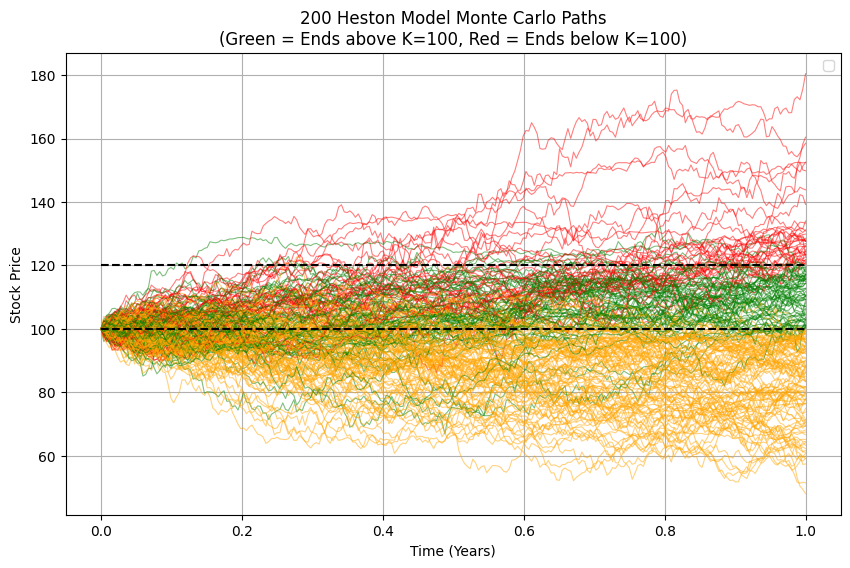

In [21]:
# Time grid
t = np.linspace(0, T, N+1)

# Simulate and plot paths
plt.figure(figsize=(10, 6))
for _ in range(n_paths):
    S, _ = simulate_heston_barrier(S0, v0, kappa, theta, sigma, rho, r, T, N, B, barrier_type='up-and-out')
    
    # Determine path color based on terminal price
    path_color = "red" if S[-1] > B else ("green" if S[-1] > K and S[-1] < B else "orange")
    
    plt.plot(t, S, color=path_color, alpha=0.5, linewidth=0.8)

plt.title(f'{n_paths} Heston Model Monte Carlo Paths\n(Green = Ends above K={K}, Red = Ends below K={K})')
plt.xlabel('Time (Years)')
plt.ylabel('Stock Price')
plt.hlines(y=[K, B], xmin=[0,0], xmax=[1,1], colors=["black", "black"], linestyles=["--", "--"])
plt.grid(True)
plt.legend()
plt.show()


In [22]:
# Price different barrier options
up_out_call = price_barrier_option(n_paths, 'call', 'up-and-out')

print(f"Up-and-Out Call Price: $ {up_out_call:.4f}")

Up-and-Out Call Price: $ 2.4186
